In [11]:
from typing import TypedDict, Literal, Annotated
from dotenv import load_dotenv
from langgraph.types import Send
from langgraph.graph import StateGraph, START, END
from langchain.chat_models import init_chat_model
from pydantic import BaseModel
from operator import add

load_dotenv()

llm = init_chat_model("openai:gpt-4o-mini")

In [12]:
class State(TypedDict):
    document: str
    summary: str
    summaries: Annotated[list[dict], add]

In [13]:
def summarize_p(state):
    paragraph = state["paragraph"]
    index = state["index"]
    response = llm.invoke(f"이 문단을 보고 3개의 문장으로 요약해 주세요. {paragraph}")

    return {
        "summaries": [
            {
                "summary": response.content,
                "index": index,
            }
        ]
    }


def dispatch_summarizers(state: State):
    chunks = state["document"].split("\n\n")

    return [
        Send("summarize_p", {"paragraph": chunk, "index": index})
        for index, chunk in enumerate(chunks)
    ]


def final_summary(state: State):
    response = llm.invoke(
        f"다음 요약들을 사용해 마지막 하나의 최종 요약을 주세요. {state['summaries']}"
    )
    return {
        "final_summary": response.content,
    }

In [ ]:
graph_builder = StateGraph(State)

graph_builder.add_node("summarize_p", summarize_p)
graph_builder.add_node("final_summary", final_summary)


graph_builder.add_conditional_edges(
    START,
    dispatch_summarizers,
    ["summarize_p"],
)

graph_builder.add_edge("summarize_p", "final_summary")
graph_builder.add_edge("final_summary", END)


graph = graph_builder.compile()

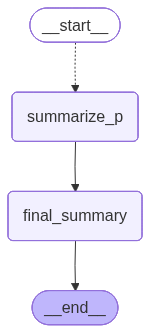

In [15]:
graph

In [16]:
with open("fed_transcript.md", "r", encoding="utf-8") as f:
    document = f.read()

for chunk in graph.stream(
    {"document": document},
    stream_mode="updates",
):
    print(chunk, "\n")

{'summarize_p': {'summaries': [{'summary': '소비자 지출의 둔화가 전반적인 조정과 성장을 반영한다. 이는 경제 활동의 감소를 나타낼 수 있다. 결과적으로, 기업과 시장은 이러한 변화에 대응해야 할 필요가 있다.', 'index': 2}]}} 

{'summarize_p': {'summaries': [{'summary': '8월에 실업률이 4.3%로 소폭 증가했습니다. 그러나 이는 지난 1년 동안 비교적 낮은 수준에서 크게 변동하지 않았습니다. 전반적으로 노동 시장은 안정적인 모습을 보이고 있습니다.', 'index': 5}]}} 

{'summarize_p': {'summaries': [{'summary': '최근 3개월 동안 고용 성장률이 월 평균 29,000명으로 크게 둔화되었습니다. 이러한 둔화의 주요 원인은 이민 감소와 노동력 참여율 감소로 인해 노동력 성장률이 감소했기 때문입니다.', 'index': 6}]}} 

{'summarize_p': {'summaries': [{'summary': '사업 투자와 장비 및 무형 자산은 지난해의 속도보다 향상되었다. 이러한 변화는 경제 활동의 회복을 나타낸다. 전반적으로, 기업들이 더 많은 투자를 진행하고 있는 것으로 보인다.', 'index': 3}]}} 

{'summarize_p': {'summaries': [{'summary': '경제 활동의 성장률이 둔화되고 있다는 최근 지표가 나타났다. 올해 상반기 GEP 성장률은 약 1.5%로, 작년 2.5%에서 감소하였다. 이러한 변화는 경제 활동의 전반적인 감소를 시사한다.', 'index': 1}]}} 

{'summarize_p': {'summaries': [{'summary': '물가 상승률이 상품에 대해 증가하면서 연초보다 높은 수치를 보이고 있습니다. 반면, 서비스 분야에서는 가격 상승률이 둔화되고 있습니다. 최근의 인플레이션 지표는 관세 변화로 인해 불균형적인 움직임을 보이고 있습니다.', 'index': 11}]}} 